# Stock Price Prediction Using Recurent Neural Networks (RNN) and Long-Short Memory Model(LSTM)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN, Dense

In [10]:
# Load data
stocks = {
    "AAPL": pd.read_csv(r"C:\Users\Ethan Scott\Downloads\Personal Project\Data-Portfolio\Python\Stock Price Prediction\AAPL.csv"),
    "AMZN": pd.read_csv(r"C:\Users\Ethan Scott\Downloads\Personal Project\Data-Portfolio\Python\Stock Price Prediction\AMZN.csv"),
    "COKE": pd.read_csv(r"C:\Users\Ethan Scott\Downloads\Personal Project\Data-Portfolio\Python\Stock Price Prediction\COKE.csv"),
    "JPM": pd.read_csv(r"C:\Users\Ethan Scott\Downloads\Personal Project\Data-Portfolio\Python\Stock Price Prediction\JPM.csv"),
    "MMM": pd.read_csv(r"C:\Users\Ethan Scott\Downloads\Personal Project\Data-Portfolio\Python\Stock Price Prediction\MMM.csv"),
    "MSFT": pd.read_csv(r"C:\Users\Ethan Scott\Downloads\Personal Project\Data-Portfolio\Python\Stock Price Prediction\MSFT.csv"),
    "PG": pd.read_csv(r"C:\Users\Ethan Scott\Downloads\Personal Project\Data-Portfolio\Python\Stock Price Prediction\PG.csv"),
    "WMT": pd.read_csv(r"C:\Users\Ethan Scott\Downloads\Personal Project\Data-Portfolio\Python\Stock Price Prediction\WMT.csv")
}

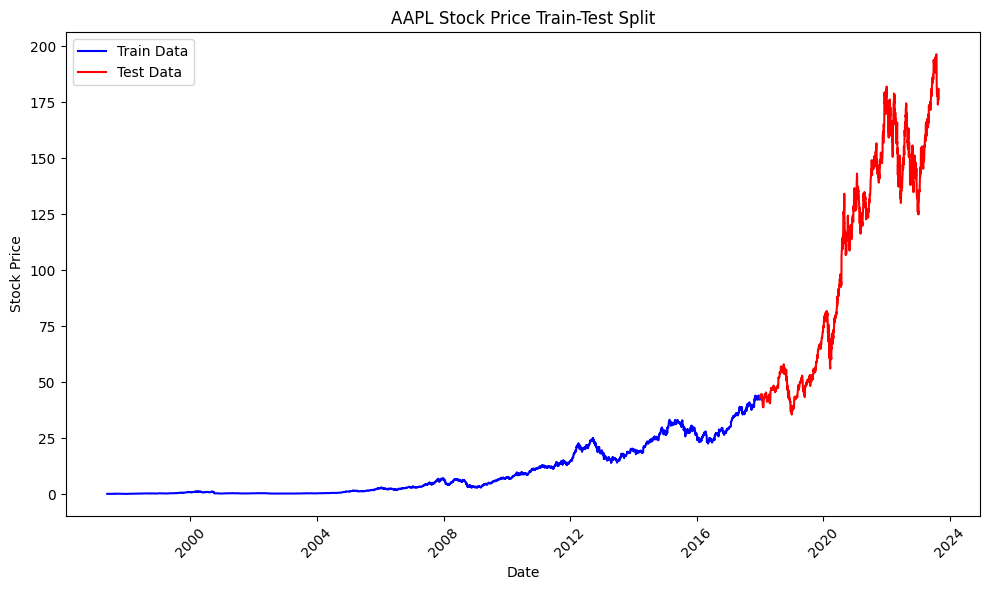

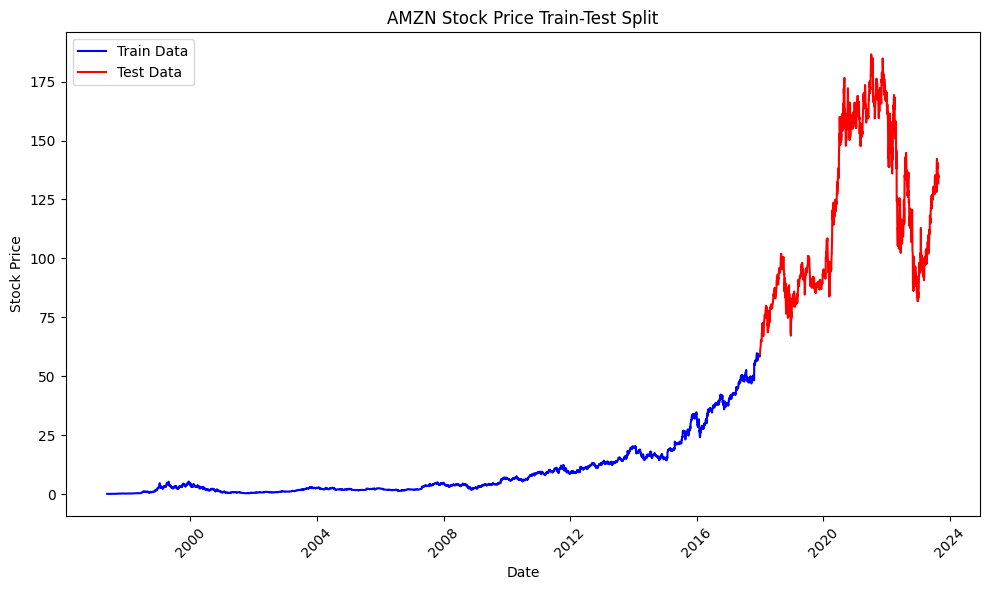

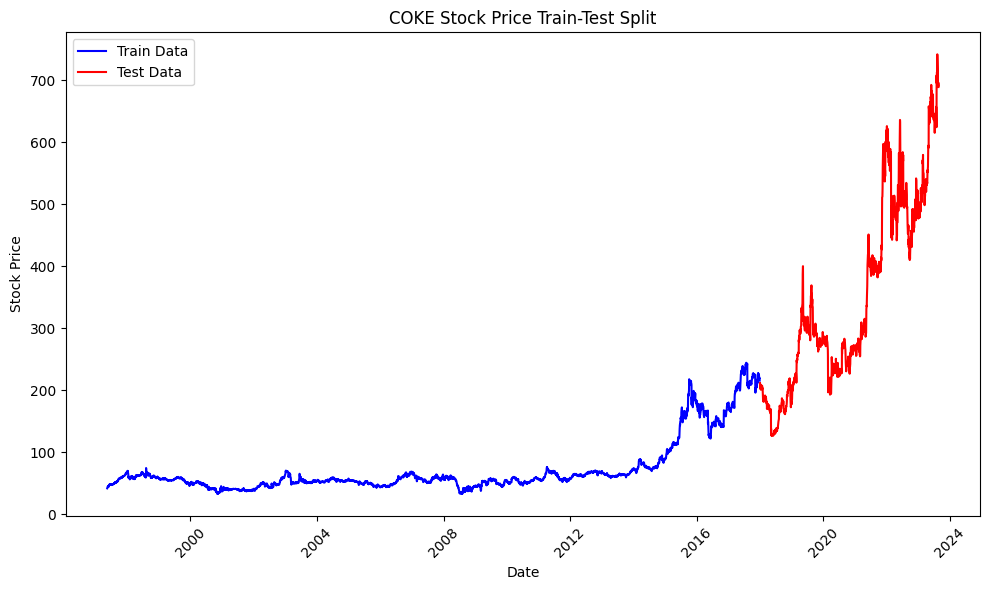

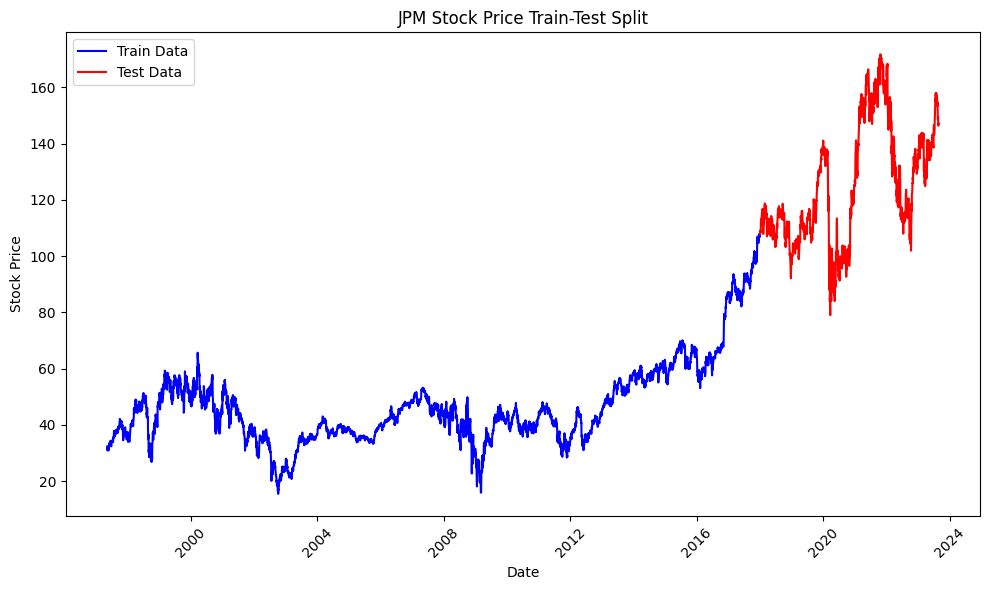

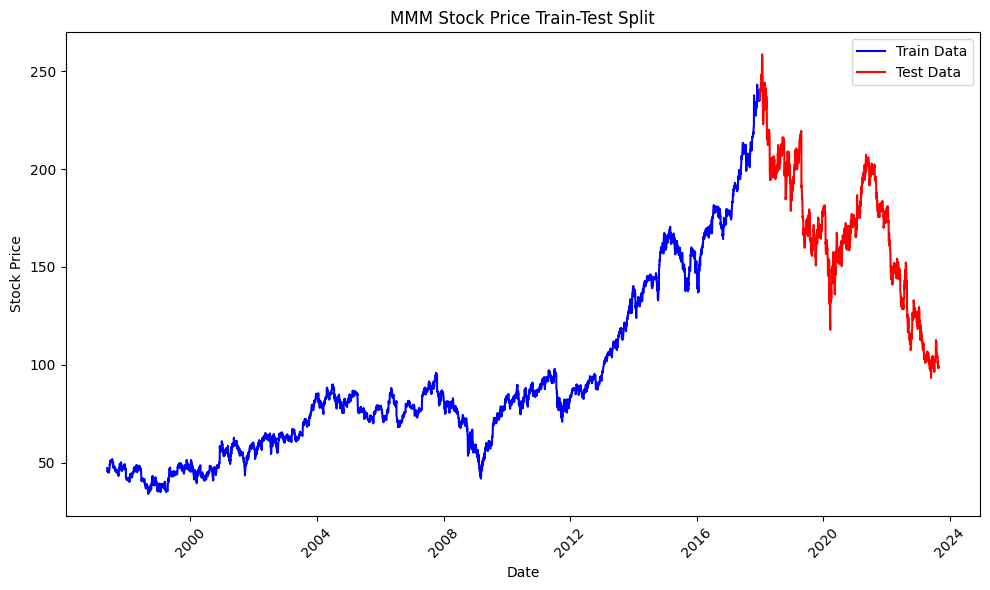

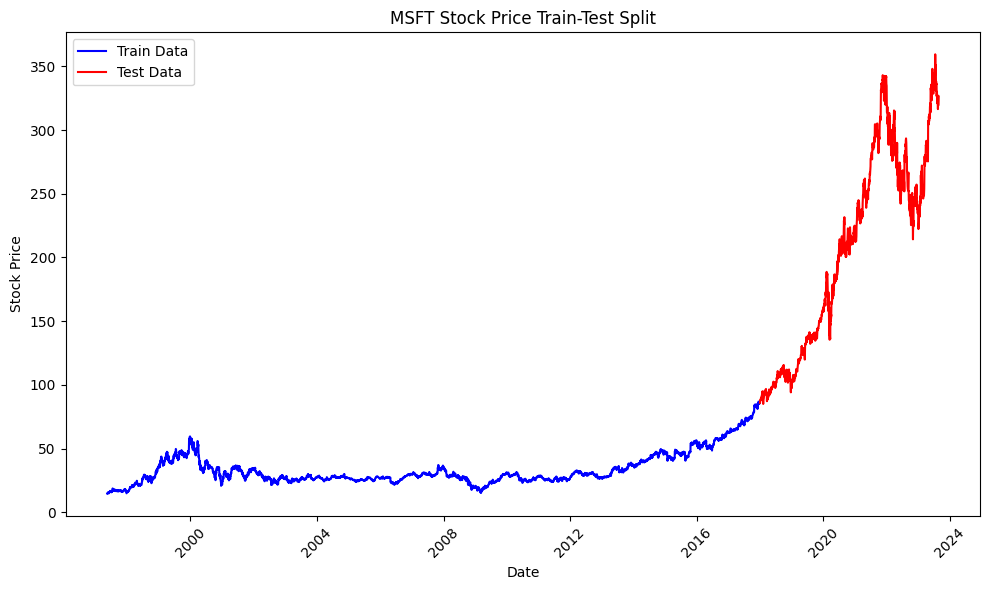

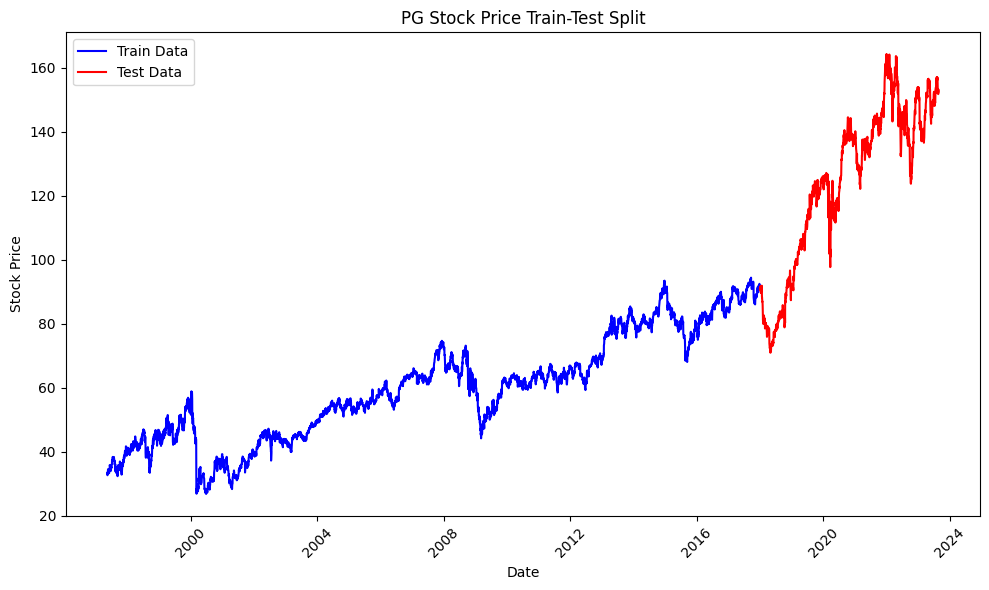

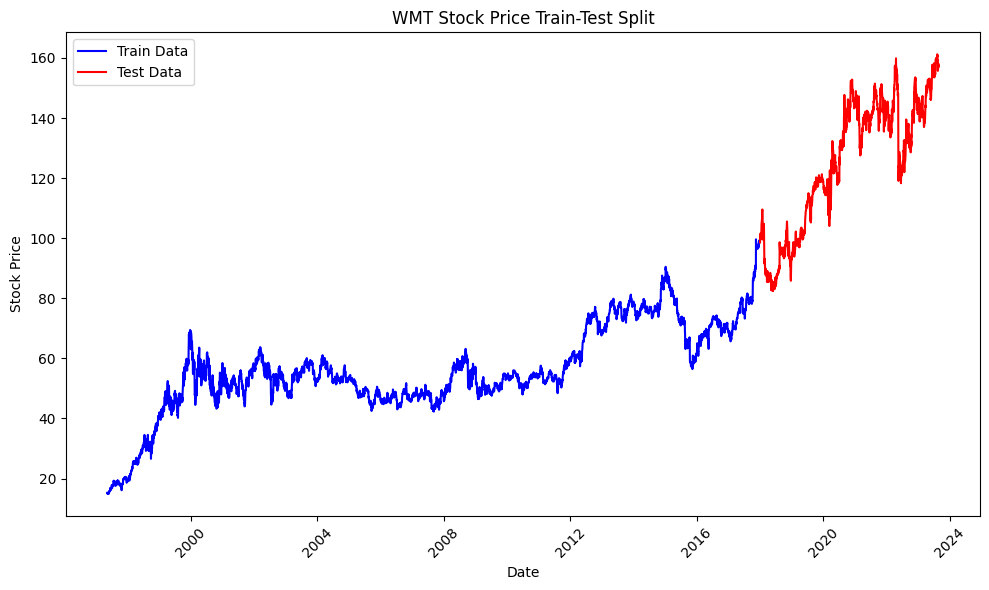

In [20]:
# Plot train and test data splits for each stock
for stock_symbol, stock_data in stocks.items():
    dates = pd.to_datetime(stock_data['Date'])
    prices = stock_data['Close']
    
    # Find the index for the split date
    split_date = pd.to_datetime('2018-01-01')
    split_index = np.where(dates >= split_date)[0][0]

    # Plot train and test data
    plt.figure(figsize=(10, 6))
    plt.plot(dates[:split_index], prices[:split_index], color='blue', label='Train Data')
    plt.plot(dates[split_index:], prices[split_index:], color='red', label='Test Data')
    plt.title(f"{stock_symbol} Stock Price Train-Test Split")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.legend()
    plt.tight_layout()
    plt.show()

In [11]:
# Scale the stock data
scalers = {}  # Store scalers for each stock
for stock_symbol, stock_data in stocks.items():
    scaler = MinMaxScaler()
    scaled_prices = scaler.fit_transform(stock_data['Close'].values.reshape(-1, 1))
    scalers[stock_symbol] = scaler
    stocks[stock_symbol]['Scaled_Close'] = scaled_prices.flatten()

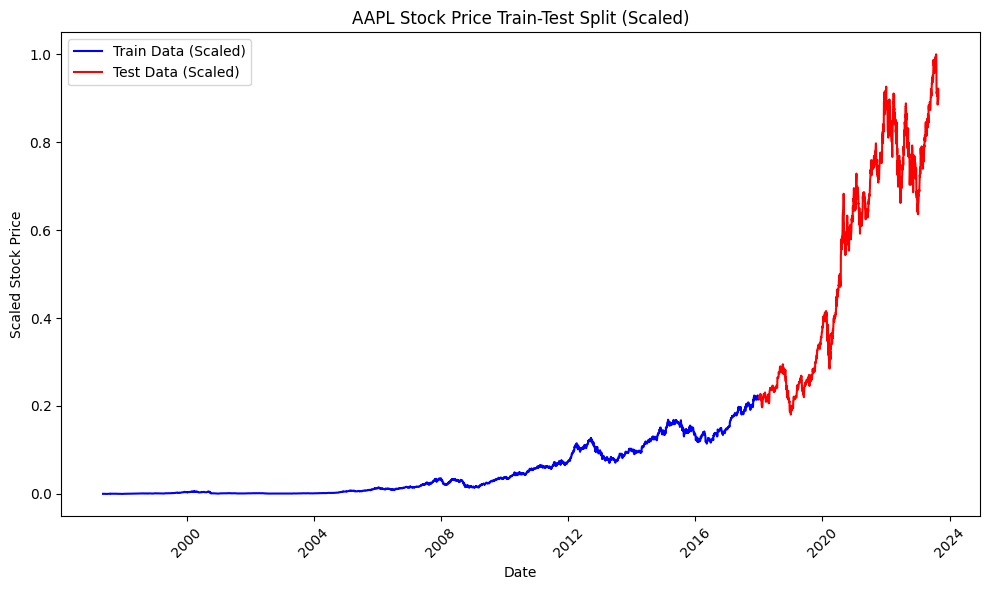

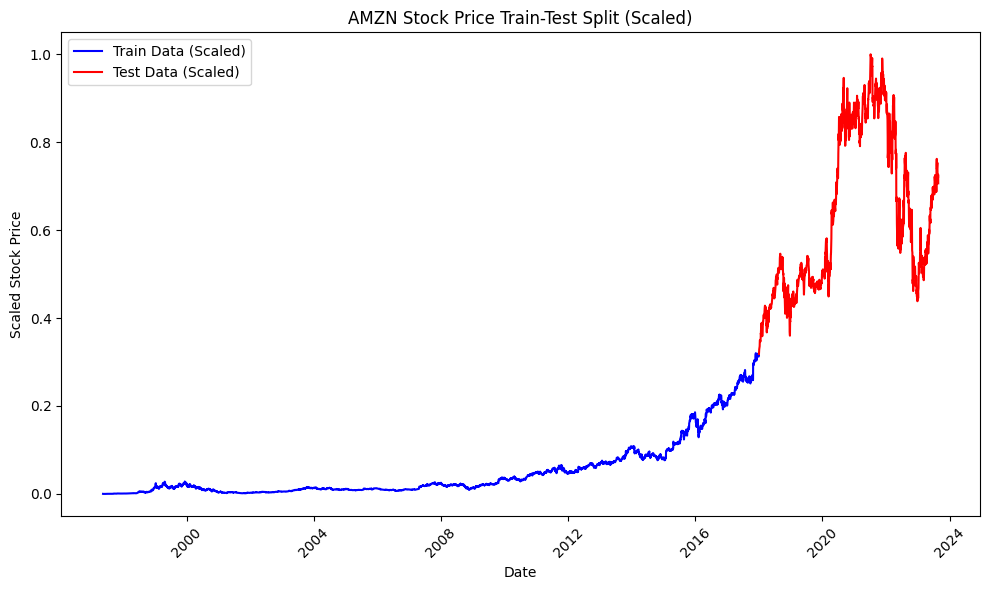

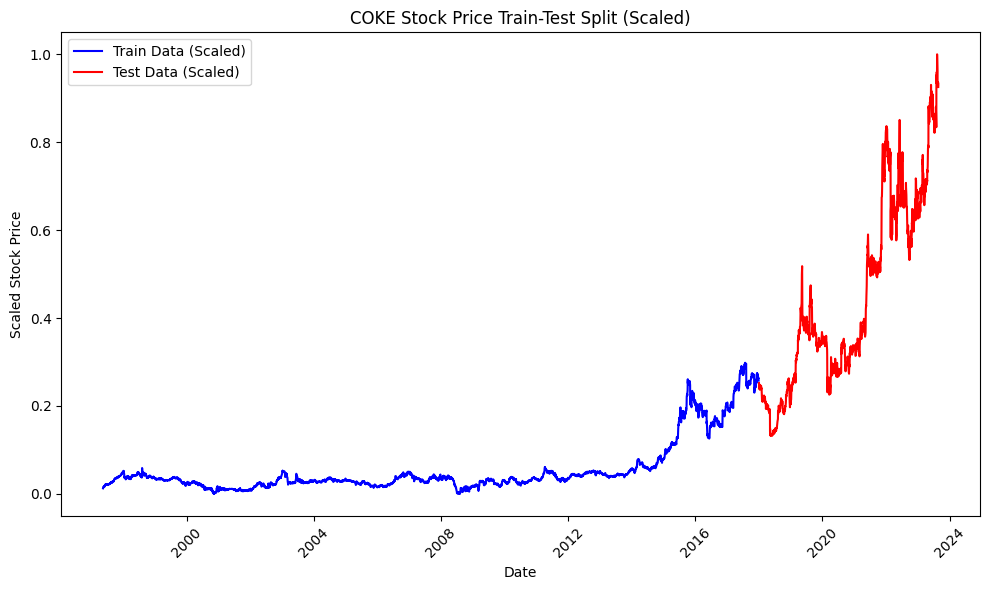

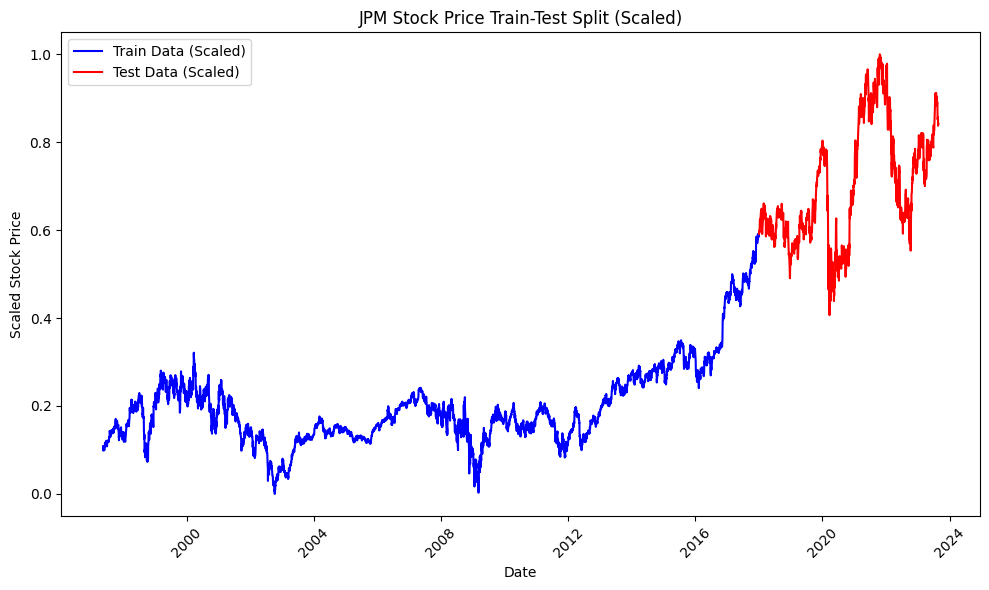

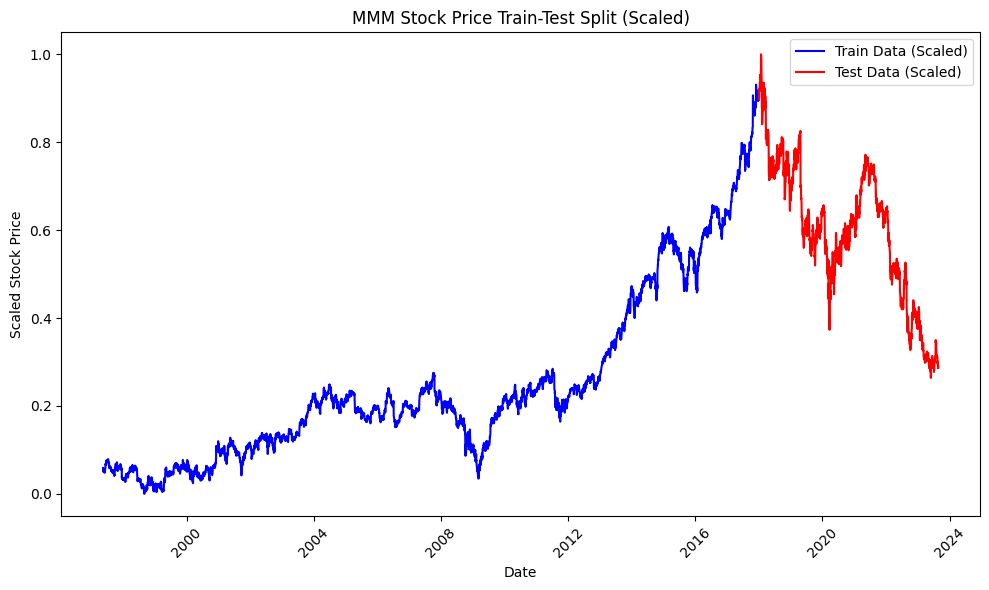

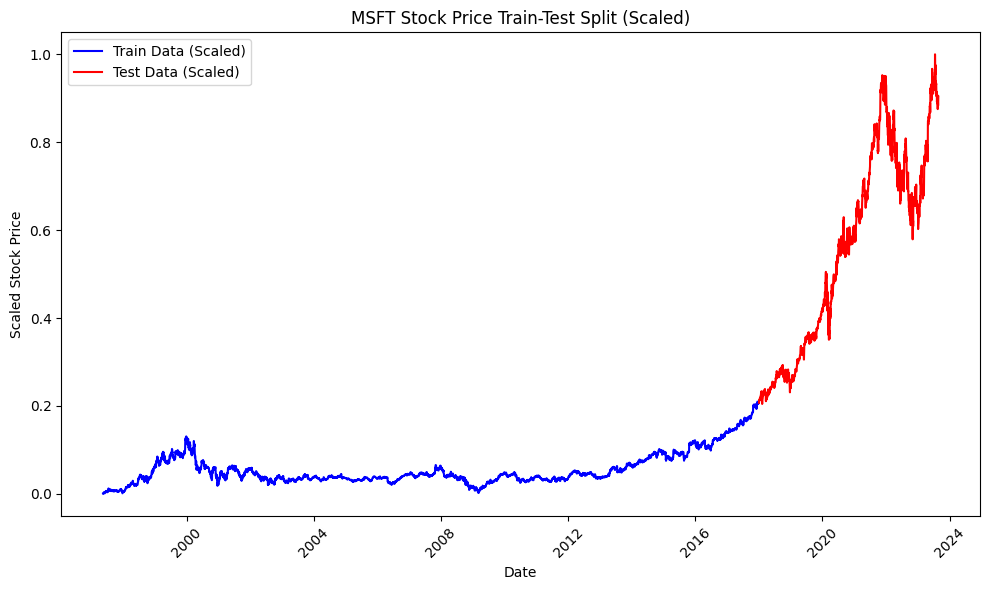

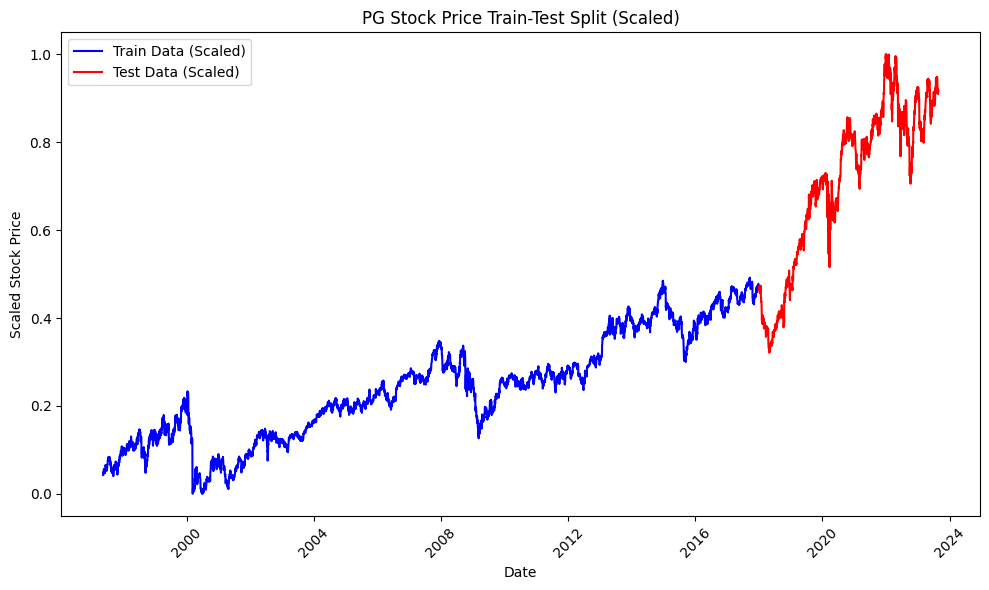

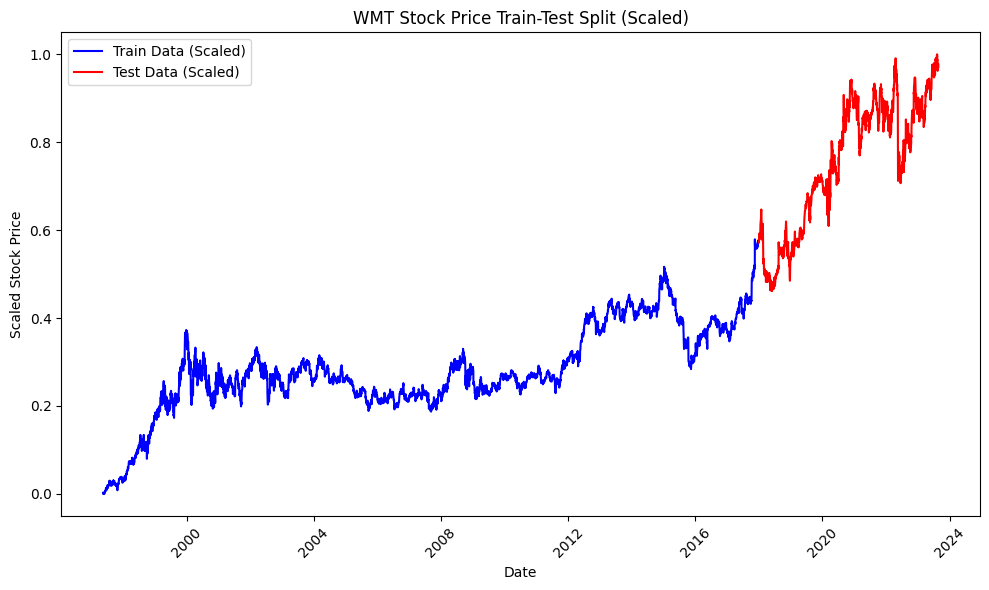

In [12]:
# Plot scaled train and test data splits for each stock
for stock_symbol, stock_data in stocks.items():
    dates = pd.to_datetime(stock_data['Date'])
    scaled_prices = stock_data['Scaled_Close']
    
    # Find the index for the split date
    split_date = pd.to_datetime('2018-01-01')
    split_index = np.where(dates >= split_date)[0][0]

    # Plot train and test data (scaled data)
    plt.figure(figsize=(10, 6))
    plt.plot(dates[:split_index], scaled_prices[:split_index], color='blue', label='Train Data (Scaled)')
    plt.plot(dates[split_index:], scaled_prices[split_index:], color='red', label='Test Data (Scaled)')
    plt.title(f"{stock_symbol} Stock Price Train-Test Split (Scaled)")
    plt.xlabel("Date")
    plt.ylabel("Scaled Stock Price")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Long Short Term Memory Model for Price Prediction

SyntaxError: invalid syntax (951648962.py, line 2)